<a href="https://colab.research.google.com/github/Marcellinus08/Deep-Learning/blob/main/WMT_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Library

In [1]:
!pip install tensorflow_datasets keras-tuner --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.3 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import keras_tuner as kt


Load Dataset

In [3]:
# Load full train dan validation set TANPA slicing
ds_train = tfds.load('wmt14_translate/de-en', split='train', as_supervised=True)
ds_val = tfds.load('wmt14_translate/de-en', split='validation', as_supervised=True)

# Ambil subset kecil agar bisa diproses cepat
ds_train = ds_train.take(10000)
ds_val = ds_val.take(2000)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/wmt14_translate/de-en/incomplete.HXWR53_1.0.0/wmt14_translate-train.tfreco…

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/wmt14_translate/de-en/incomplete.HXWR53_1.0.0/wmt14_translate-validation.t…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/wmt14_translate/de-en/incomplete.HXWR53_1.0.0/wmt14_translate-test.tfrecor…

Dataset wmt14_translate downloaded and prepared to /root/tensorflow_datasets/wmt14_translate/de-en/1.0.0. Subsequent calls will reuse this data.


Konversi data dari tf.data.Dataset ke list teks (TANPA .numpy())

In [4]:
# Konversi data dari tf.data.Dataset ke list teks (TANPA .numpy())
src_train, tgt_train = zip(*[(de.decode('utf-8'), en.decode('utf-8')) for de, en in tfds.as_numpy(ds_train)])
src_val, tgt_val = zip(*[(de.decode('utf-8'), en.decode('utf-8')) for de, en in tfds.as_numpy(ds_val)])


Convert to sequences

In [5]:
src_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
tgt_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')

src_tokenizer.fit_on_texts(src_train)
tgt_tokenizer.fit_on_texts(['<start> ' + text + ' <end>' for text in tgt_train])

# Convert to sequences
src_train_seq = src_tokenizer.texts_to_sequences(src_train)
tgt_train_seq = tgt_tokenizer.texts_to_sequences(['<start> ' + text + ' <end>' for text in tgt_train])
src_val_seq = src_tokenizer.texts_to_sequences(src_val)
tgt_val_seq = tgt_tokenizer.texts_to_sequences(['<start> ' + text + ' <end>' for text in tgt_val])

# Padding

Padding

In [6]:
max_src_len = max(len(seq) for seq in src_train_seq)
max_tgt_len = max(len(seq) for seq in tgt_train_seq)

src_train_pad = tf.keras.preprocessing.sequence.pad_sequences(src_train_seq, maxlen=max_src_len, padding='post')
tgt_train_pad = tf.keras.preprocessing.sequence.pad_sequences(tgt_train_seq, maxlen=max_tgt_len, padding='post')
src_val_pad = tf.keras.preprocessing.sequence.pad_sequences(src_val_seq, maxlen=max_src_len, padding='post')
tgt_val_pad = tf.keras.preprocessing.sequence.pad_sequences(tgt_val_seq, maxlen=max_tgt_len, padding='post')


Prepare decoder inputs and outputs

In [7]:
decoder_input_train = tgt_train_pad[:, :-1]
decoder_output_train = tgt_train_pad[:, 1:]
decoder_input_val = tgt_val_pad[:, :-1]
decoder_output_val = tgt_val_pad[:, 1:]

Model Architecture

In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense

vocab_src = len(src_tokenizer.word_index) + 1
vocab_tgt = len(tgt_tokenizer.word_index) + 1
embedding_dim = 256
lstm_units = 512

# Encoder
encoder_inputs = Input(shape=(None,))
enc_emb = Embedding(vocab_src, embedding_dim)(encoder_inputs)
encoder_lstm = LSTM(lstm_units, return_state=True)
_, state_h, state_c = encoder_lstm(enc_emb)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(None,))
dec_emb = Embedding(vocab_tgt, embedding_dim)(decoder_inputs)
decoder_lstm = LSTM(lstm_units, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)
decoder_dense = Dense(vocab_tgt, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define full model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, None, 256) │ 11,606,784 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, None, 256) │  8,427,264 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 512),     │  1,574,912 │ embedding[0][0]   │
│                     │ (None, 512),      │            │                   │
│                     │ (None, 512)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, None,     │  1,574,912 │ embedding_1[0][0… │
│                     │ 512), (None,      │            │ lstm[0][1],       │
│                     │ 512), (None,      │            │ lstm[0][2]        │
│                     │ 512)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, None,      │ 16,887,447 │ lstm_1[0][0]      │
│                     │ 32919)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 40,071,319 (152.86 MB)

 Trainable params: 40,071,319 (152.86 MB)

 Non-trainable params: 0 (0.00 B)

Training

In [9]:
history = model.fit(
    [src_train_pad, decoder_input_train], decoder_output_train,
    validation_data=([src_val_pad, decoder_input_val], decoder_output_val),
    batch_size=64,
    epochs=5
)


Epoch 1/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 183s 1s/step - accuracy: 0.8697 - loss: 2.5261 - val_accuracy: 0.9340 - val_loss: 0.4969
Epoch 2/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 206s 1s/step - accuracy: 0.9085 - loss: 0.7294 - val_accuracy: 0.9360 - val_loss: 0.4864
Epoch 3/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.9118 - loss: 0.6975 - val_accuracy: 0.9365 - val_loss: 0.4793
Epoch 4/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 197s 1s/step - accuracy: 0.9120 - loss: 0.6829 - val_accuracy: 0.9370 - val_loss: 0.4774
Epoch 5/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 176s 1s/step - accuracy: 0.9137 - loss: 0.6591 - val_accuracy: 0.9378 - val_loss: 0.4745


Evaluation & Visualization

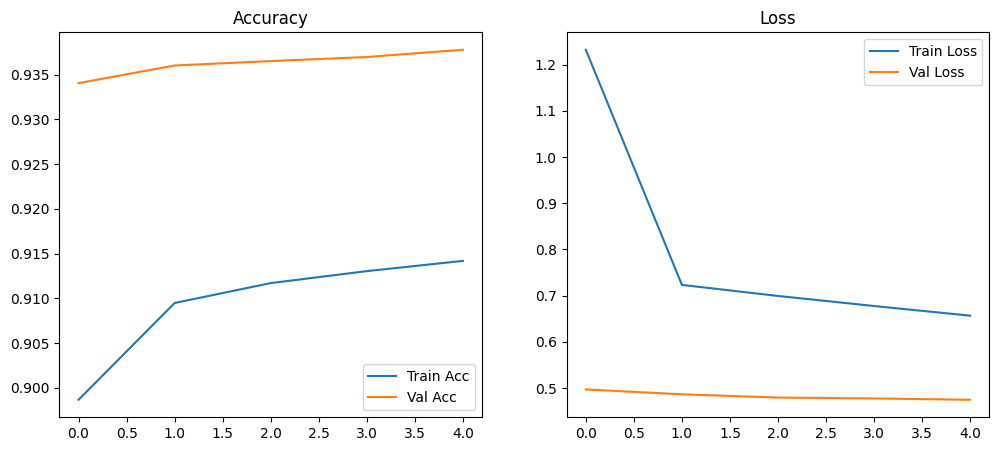

In [10]:
# Accuracy & Loss plots
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.legend()
plt.show()


In [ ]:
batch_size = 128  # Atur sesuai kekuatan GPU/TPU, bisa coba 32 atau 16 jika masih OOM

y_true_all = []
y_pred_all = []

for i in range(0, len(src_val_pad), batch_size):
    src_batch = src_val_pad[i:i+batch_size]
    dec_input_batch = decoder_input_val[i:i+batch_size]
    dec_output_batch = decoder_output_val[i:i+batch_size]

    # Prediksi
    y_pred_proba = model.predict([src_batch, dec_input_batch], verbose=0)

    # Flatten target dan prediksi
    y_true = dec_output_batch.flatten()
    y_pred = y_pred_proba.reshape(-1, vocab_tgt)
    y_pred_labels = np.argmax(y_pred, axis=1)

    # Binary labeling
    y_true_binary = (y_true != 0).astype(int)
    y_pred_binary = (y_pred_labels == y_true).astype(int)

    y_true_all.extend(y_true_binary)
    y_pred_all.extend(y_pred_binary)

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_true_all, y_pred_all)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})', color='darkorange')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Token-Level Prediction')
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [ ]:
import keras_tuner as kt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

In [ ]:
def build_model(hp):
    embedding_dim = hp.Choice('embedding_dim', [128, 256])
    rnn_units = hp.Choice('rnn_units', [256, 512])
    dropout_rate = hp.Float('dropout_rate', 0.2, 0.5, step=0.1)

    # Encoder
    encoder_inputs = Input(shape=(None,))
    x = Embedding(vocab_src, embedding_dim, mask_zero=True)(encoder_inputs)
    for _ in range(2):
        x = LSTM(rnn_units, return_sequences=True, dropout=dropout_rate)(x)
    encoder_outputs = x

    # Decoder
    decoder_inputs = Input(shape=(None,))
    y = Embedding(vocab_tgt, embedding_dim, mask_zero=True)(decoder_inputs)
    for _ in range(2):
        y = LSTM(rnn_units, return_sequences=True, dropout=dropout_rate)(y)
    decoder_outputs = Dense(vocab_tgt, activation='softmax')(y)

    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

    learning_rate = hp.Choice('learning_rate', [1e-3, 5e-4, 1e-4])
    model.compile(
        optimizer=Adam(learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

Setup Tuner dan Jalankan

In [ ]:
# Buat tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,  # Ubah jika ingin eksplorasi lebih banyak kombinasi
    executions_per_trial=1,
    directory='tuning_dir',
    project_name='seq2seq_translation'
)

# Callback untuk stop dini
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

# Jalankan hypertuning
tuner.search(
    [src_train_pad, decoder_input_train],
    decoder_output_train,
    validation_data=([src_val_pad, decoder_input_val], decoder_output_val),
    epochs=5,
    batch_size=128,
    callbacks=[stop_early]
)


 Model Terbaik

In [ ]:
# Dapatkan model terbaik
best_model = tuner.get_best_models(num_models=1)[0]

# Lihat parameter terbaik
best_hyperparams = tuner.get_best_hyperparameters(1)[0]
print("✅ Best Hyperparameters:")
print(f"embedding_dim: {best_hyperparams.get('embedding_dim')}")
print(f"rnn_units: {best_hyperparams.get('rnn_units')}")
print(f"dropout_rate: {best_hyperparams.get('dropout_rate')}")
print(f"learning_rate: {best_hyperparams.get('learning_rate')}")
